## Importing Libraries

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple, Dict
from pandas import DataFrame
import seaborn as sns

## Cleaning and K Means

In [ ]:
def remove_words_before(name: str) -> str:
    """
    Remove words before specified words in a name.
    
    Args:
    - name (str): Name to process
    
    Returns:
    - str: Name with words before specified words removed
    """
    specified_words = ['Mega', 'Alolan', 'Partner', 'Hisuian', 'Galarian', 'Paldean', 'Primal', 'Heat', 'Wash',
                       'Frost', 'Fan', 'Mow', 'White', 'Black', 'Dusk Mane', 'Dawn Wings', 'Ultra']
    for word in specified_words:
        name = re.sub(r'.*?(?='+re.escape(word)+')', '', name)
    return name.strip()


def preprocess_data(data: DataFrame) -> DataFrame:
    """
    Preprocess the Pokémon data by removing words before specified words in the 'Names' column.
    
    Args:
    - data (DataFrame): Input DataFrame
    
    Returns:
    - DataFrame: Preprocessed DataFrame
    """
    data['Names_clean'] = data['Names'].apply(remove_words_before)
    return data


def perform_kmeans_clustering(data: DataFrame, selected_features: List[str], num_clusters: int) -> DataFrame:
    """
    Perform k-means clustering on the selected features of the Pokémon data.
    
    Args:
    - data (DataFrame): Input DataFrame
    - selected_features (list): List of selected features
    - num_clusters (int): Number of clusters to generate
    
    Returns:
    - DataFrame: DataFrame with cluster labels assigned
    """
    pokemon_features = data[selected_features]
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(pokemon_features)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(normalized_features)

    data['Cluster'] = kmeans.labels_

    return data


def analyze_clusters(data: DataFrame, selected_features: List[str]) -> Tuple[DataFrame, DataFrame]:
    """
    Analyze the clusters based on their mean values and type counts.
    
    Args:
    - data (DataFrame): Input DataFrame with cluster labels
    - selected_features (list): List of selected features
    
    Returns:
    - DataFrame: Cluster means of selected features
    - DataFrame: Type counts within each cluster
    """
    cluster_means = data.groupby('Cluster')[selected_features].mean()
    type_counts = data.groupby(['Cluster', 'Type1'])['Id'].count().unstack()
    return cluster_means, type_counts


def save_data_to_csv(data: DataFrame, filename: str) -> None:
    """
    Save the Pokémon data with cluster labels to a CSV file.
    
    Args:
    - data (DataFrame): Input DataFrame
    - filename (str): File name for the CSV
    
    Returns:
    - None
    """
    data.drop('Unnamed: 0', axis=1, inplace=True)
    data.to_csv(filename, index=False)
    print(f"Data saved to {filename}")


def plot_elbow_method(data: DataFrame, selected_features: List[str], max_clusters: int) -> None:
    """
    Plot the elbow method to determine the optimal number of clusters.
    
    Args:
    - data (DataFrame): Input DataFrame for clustering
    - selected_features (list): List of selected features
    - max_clusters (int): Maximum number of clusters to consider
    
    Returns:
    - None
    """
    wcss = []
    for n in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), wcss)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method')
    plt.show()


# Read the Pokémon data from CSV
pokemon_data = pd.read_csv('pokemon.csv')

# Preprocess the data
pokemon_data = preprocess_data(pokemon_data)

# Set the desired features for clustering
selected_features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

# Plot the elbow method to determine the optimal number of clusters
max_clusters = 10
plot_elbow_method(pokemon_data[selected_features], selected_features, max_clusters)

# Perform k-means clustering
num_clusters = 6
pokemon_data = perform_kmeans_clustering(pokemon_data, selected_features, num_clusters)

# Analyze the clusters
cluster_means, type_counts = analyze_clusters(pokemon_data, selected_features)
print(cluster_means)
print(type_counts)

# Save the data with cluster labels to a new CSV file
save_data_to_csv(pokemon_data, 'pokemon_cluster.csv')


## Exploring Crosstabs Plots

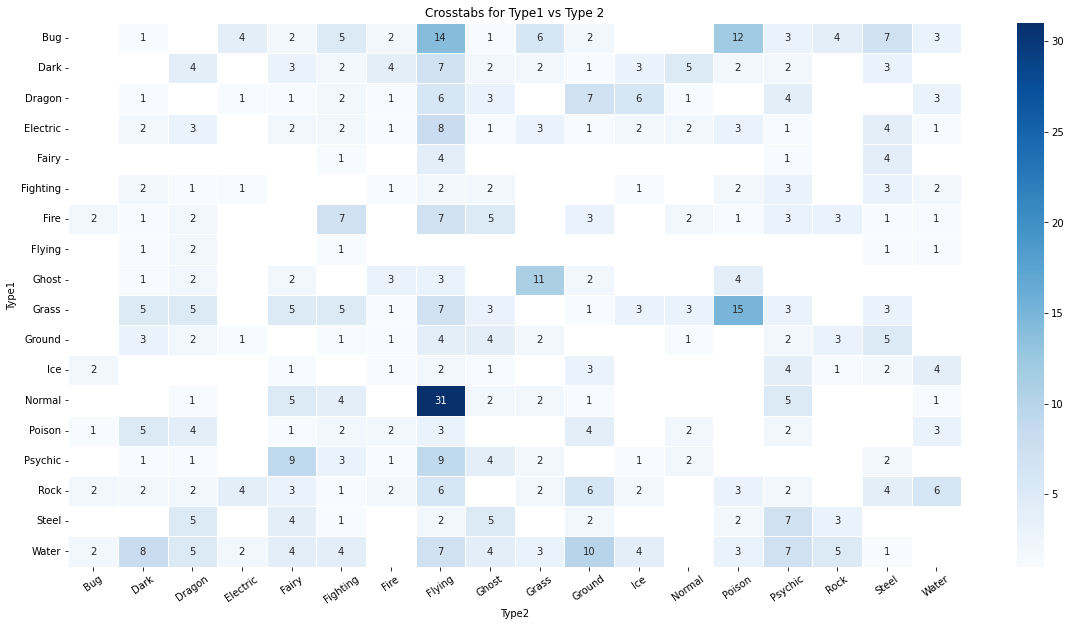

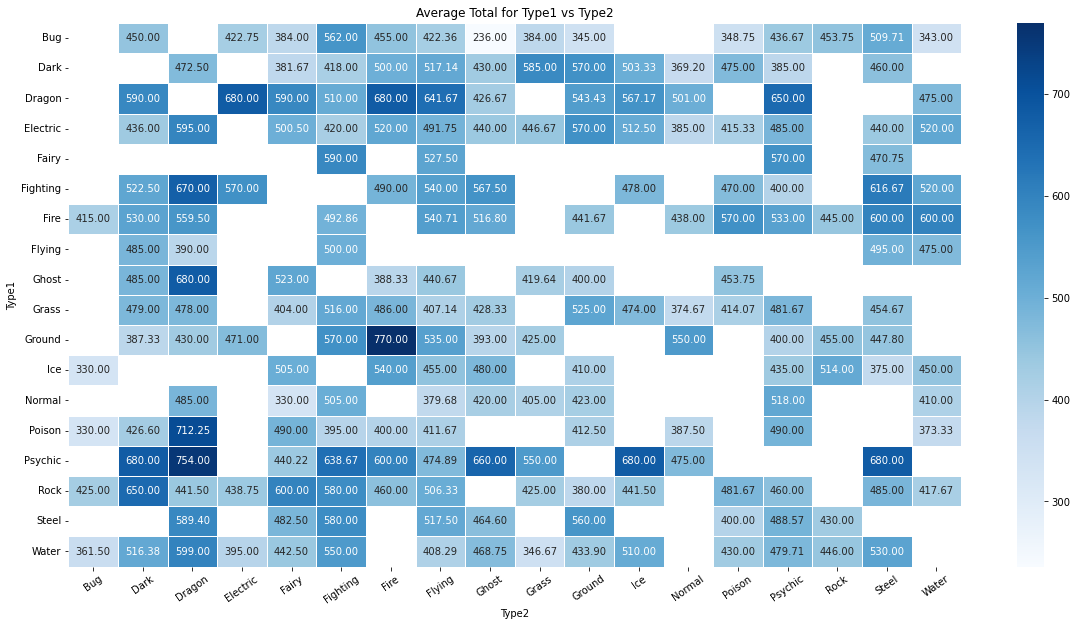

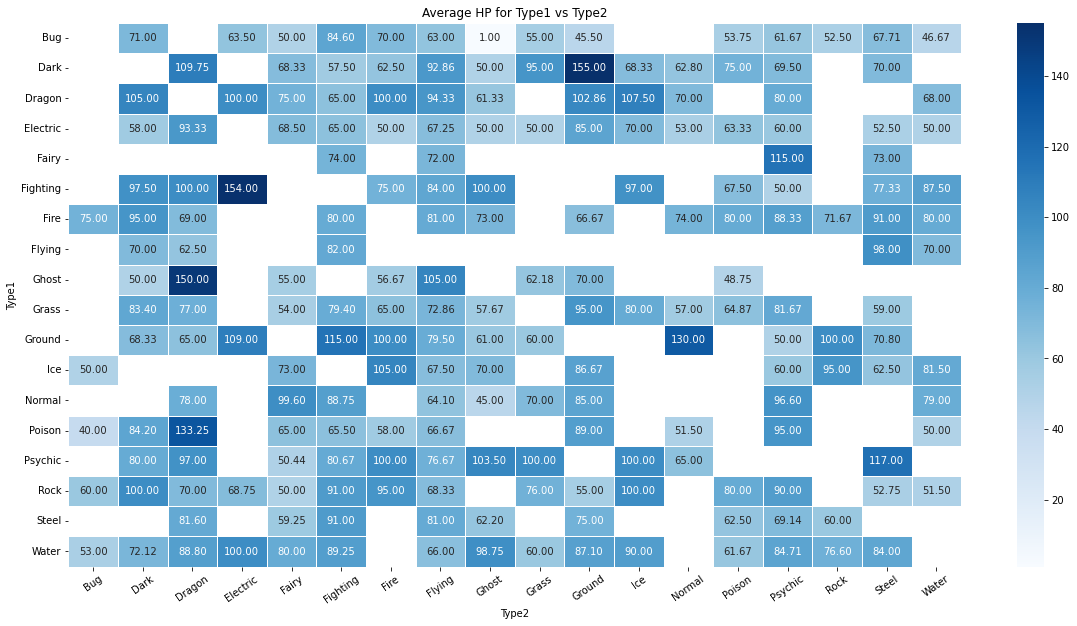

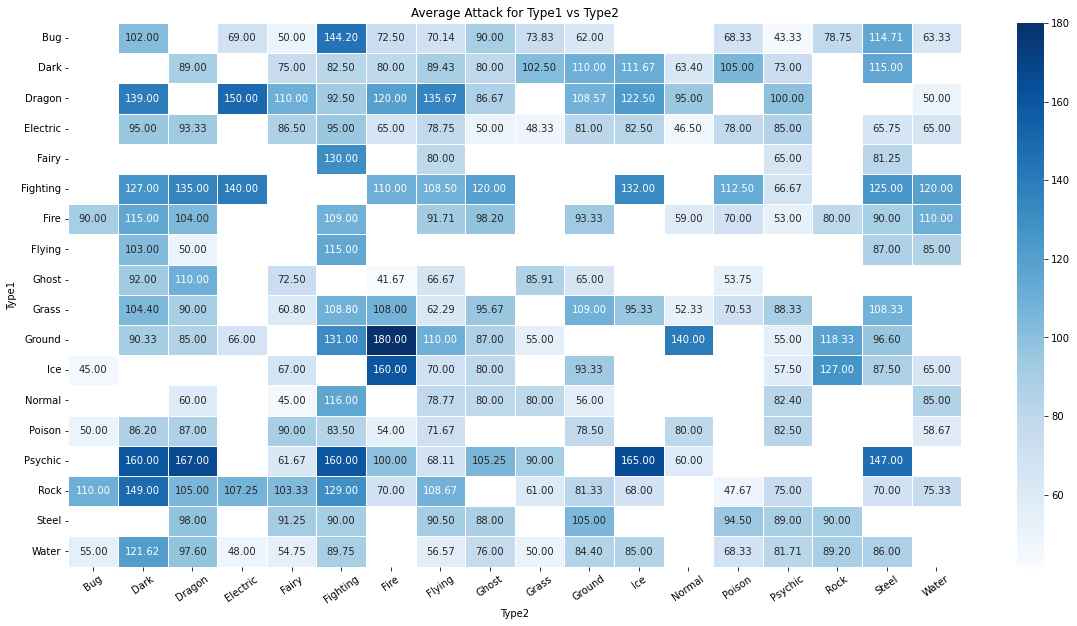

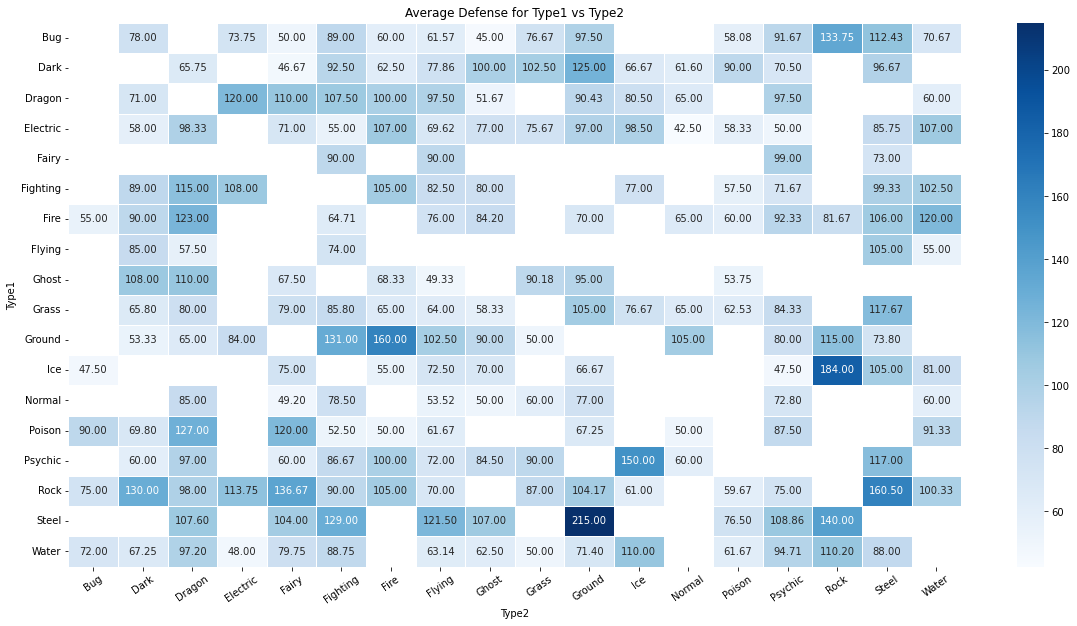

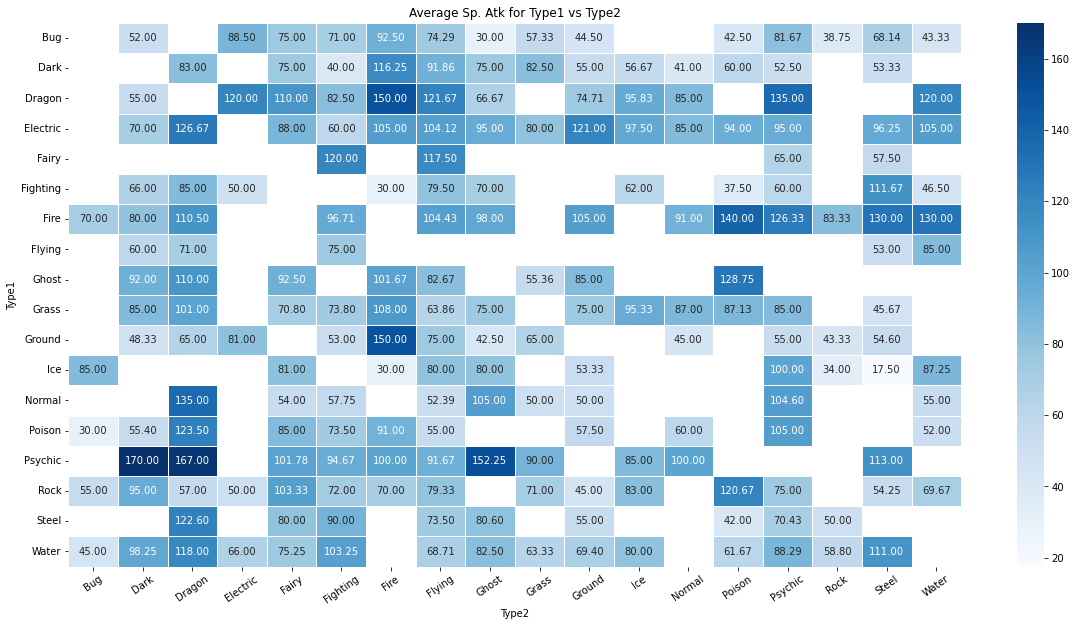

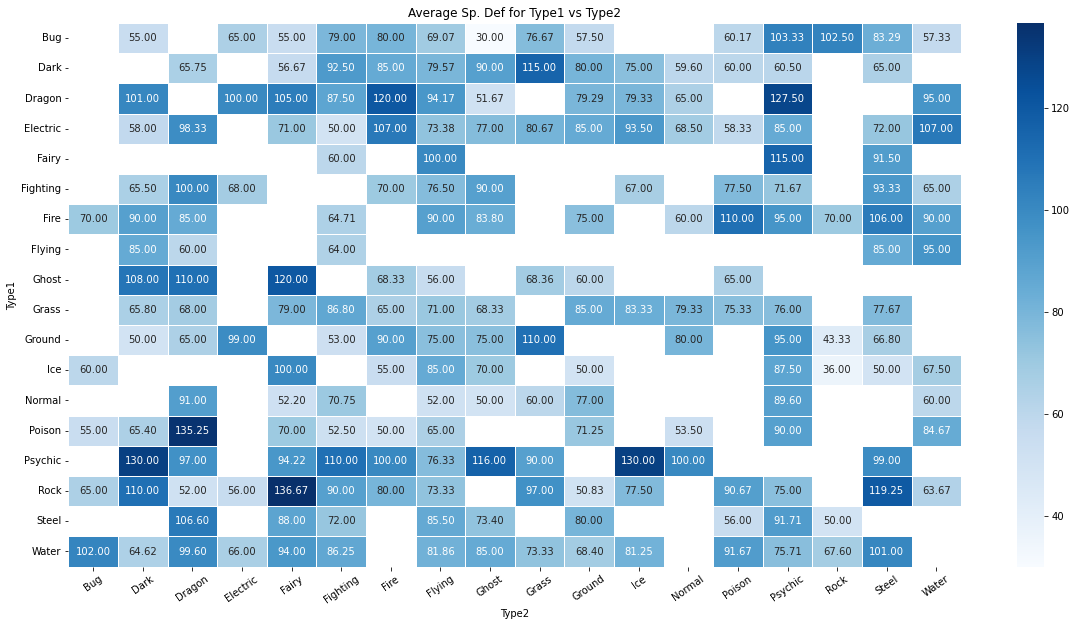

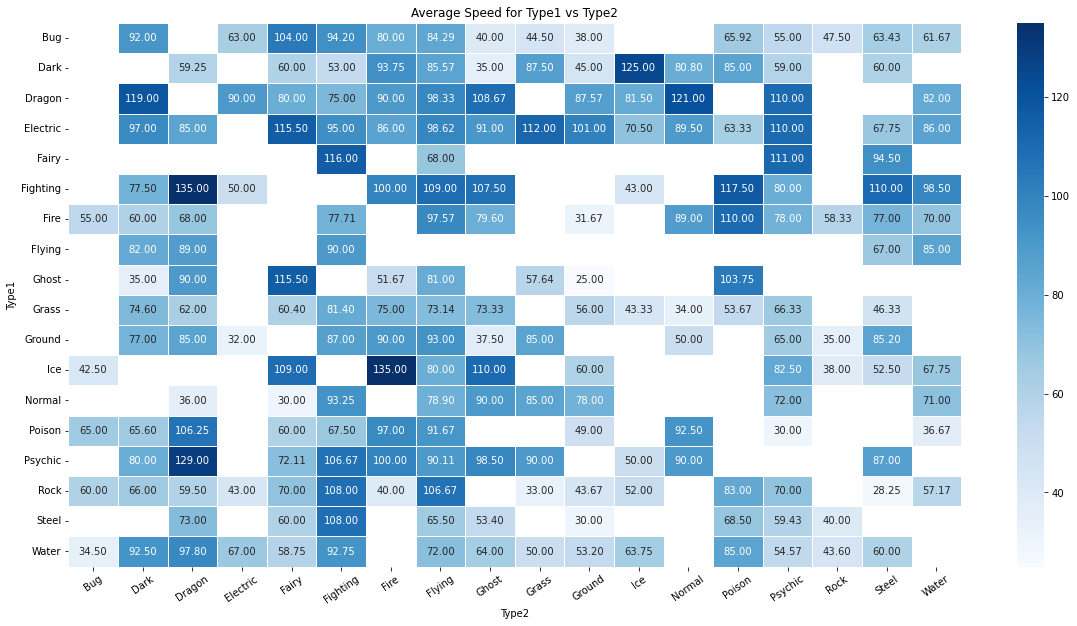

In [348]:

def plot_heatmap(data: DataFrame, index: str, columns: str, values: str = 'None', figsize: tuple = (20, 10)) -> None:
    """
    Plot a heatmap for the given data with specified index, columns, and values.
    
    Args:
    - data (DataFrame): Input DataFrame
    - index (str): Column name for the index
    - columns (str): Column name for the columns
    - values (str): Column name for the values
    - figsize (tuple): Figure size (default: (20, 10))
    
    Returns:
    - None
    """
    
    if values != 'None':
        
        plt.subplots(figsize=figsize)

        heatmap_data = data[data[columns] != 'None'].pivot_table(index=index, columns=columns, values=values, aggfunc='mean')

        sns.heatmap(
            heatmap_data,
            linewidths=1,
            annot=True,
            fmt='.2f',  # Set the number format to two decimal places
            cmap="Blues"
        )

        plt.xticks(rotation=35)
        plt.title(f'Average {values} for Type1 vs Type2')
        plt.show()
    else:
        plt.subplots(figsize=figsize)
        sns.heatmap(
        pokemon_data[pokemon_data['Type2']!='None'].groupby(['Type1', 'Type2']).size().unstack(),
        linewidths=1,
        annot=True,
        cmap="Blues")
        
        plt.xticks(rotation=35)
        plt.title('Crosstabs for Type1 vs Type 2')
        plt.show()
        
        

# Read the Pokémon data from CSV
pokemon_data = pd.read_csv('pokemon.csv')

# Plot the size heatmap for 'Type1' and 'Type2'
plot_heatmap(pokemon_data, 'Type1', 'Type2', figsize=(20, 10))


# Plot the heatmap for 'Total' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'Total', figsize=(20, 10))

# Plot the heatmap for 'HP' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'HP', figsize=(20, 10))

# Plot the heatmap for 'Attack' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'Attack', figsize=(20, 10))

# Plot the heatmap for 'Defense' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'Defense', figsize=(20, 10))

# Plot the heatmap for 'Sp. Atk' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'Sp. Atk', figsize=(20, 10))

# Plot the heatmap for 'Sp. Def' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'Sp. Def', figsize=(20, 10))

# Plot the heatmap for 'Speed' attribute
plot_heatmap(pokemon_data, 'Type1', 'Type2', 'Speed', figsize=(20, 10))
